In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model # new!
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM
from tensorflow.keras.layers import Input, concatenate, Flatten # new! 
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [2]:
# output directory name:
output_dir = 'model_output/conv-multiinput'

# training:
epochs = 4
batch_size = 32

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# convolutional layer architecture:
n_conv = 256 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 64
dropout = 0.5

In [3]:
data = pd.read_csv("./data/groundtruth.csv")

In [4]:
# combining UFS sentences and CFS sentences into FC sentences
data.loc[data['Verdict'] == 1, 'label'] = 1
data.loc[data['Verdict'] == 0, 'label'] = 1
data.loc[data['Verdict'] == -1, 'label'] = 0

data.head()

,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict,label
0,26,"You know, I saw a movie - ""Crocodile Dundee.""",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,9,26,0.000000,0,1.0
1,80,We're consuming 50 percent of the world's coca...,Michael Dukakis,Governor,DEMOCRAT,1988-09-25.txt,8,80,-0.740979,1,1.0
2,129,That answer was about as clear as Boston harbor.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,9,129,0.000000,-1,0.0
3,131,Let me help the governor.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,5,131,0.212987,-1,0.0
4,172,We've run up more debt in the last eight years...,Michael Dukakis,Governor,DEMOCRAT,1988-09-25.txt,22,172,-0.268506,1,1.0


In [5]:
data['Sentiment'].isna().sum()

0

( 0.000000    314
 -0.395988      1
 -0.323290      1
  0.516098      1
  0.538688      1
             ... 
  0.597432      1
 -0.248064      1
  0.492126      1
  0.501138      1
  0.844495      1
 Name: Sentiment, Length: 719, dtype: int64,
 <AxesSubplot: ylabel='Frequency'>)

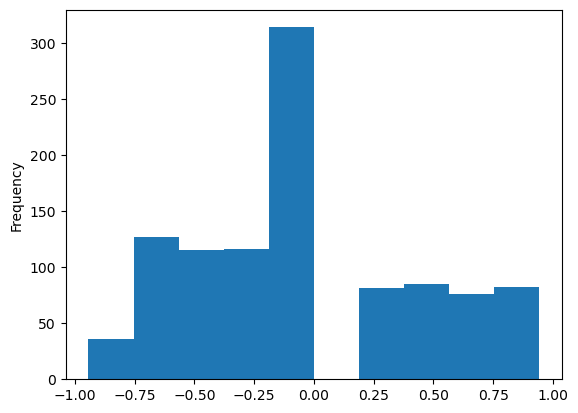

In [6]:
data['Sentiment'].value_counts(), data.Sentiment.plot.hist()

In [7]:
data['Verdict'].value_counts()

-1    731
 1    238
 0     63
Name: Verdict, dtype: int64

<AxesSubplot: ylabel='Frequency'>

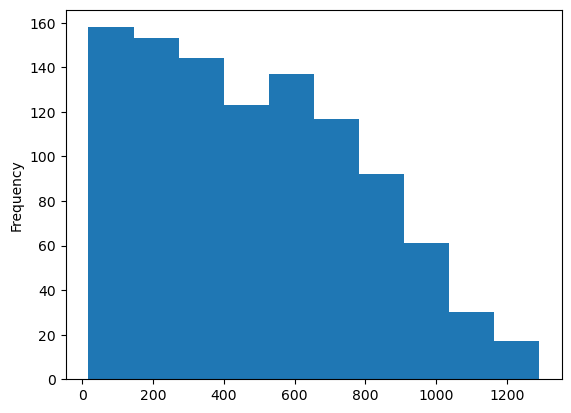

In [8]:
data['Line_number'].value_counts()
data.Line_number.plot.hist()

<AxesSubplot: ylabel='Frequency'>

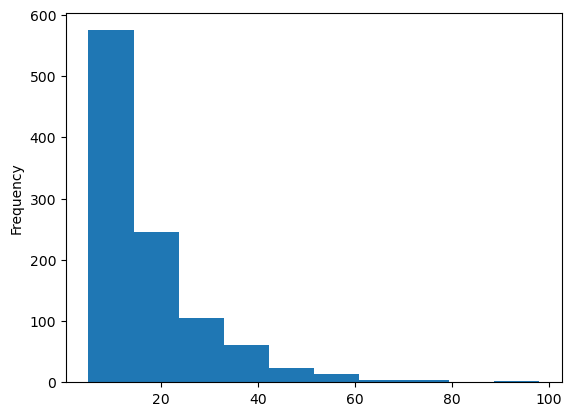

In [9]:
data.Length.plot.hist()

In [10]:
np.percentile(data.Length,95)

41.0

In [11]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1].astype(np.int64)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.20, random_state = 0)

In [13]:
x_train.Text

144                               So let me get to that.
798    If we have a Democratic Congress next year, an...
758       We have differences about how to achieve them.
352    I'm not satisfied until every American enjoys ...
725    It's not going to happen overnight; it certain...
                             ...                        
277    But more importantly, with respect to the ques...
763    Let's go to work and end this fiasco in Centra...
835    That had nothing to do with the other thing of...
559    And that is one of the challenges that America...
684    And I don't want to do that, and I won't do that.
Name: Text, Length: 825, dtype: object

In [14]:
# # Tokenize the text data
tokenizer = Tokenizer(
    num_words = 1000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    oov_token = '<UNK',
    char_level=False
)
tokenizer.fit_on_texts(x_train.Text)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(x_train.Text)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen, value=0.0)

In [15]:
# Output the results

print("Word index:\n", word_index)
print("\nTraining sequences:\n", train_sequences)
print("maxlen: ", maxlen)
print("\nPadded training sequences:\n", train_padded)
print("\nPadded training shape:", train_padded.shape)
print("Training sequences data type:", type(train_sequences))
print("Padded Training sequences data type:", type(train_padded))

Word index:
 {'<UNK': 1, 'the': 2, 'to': 3, 'and': 4, 'of': 5, 'i': 6, 'that': 7, 'in': 8, 'a': 9, 'we': 10, 'is': 11, 'have': 12, 'it': 13, 'for': 14, 'you': 15, 'our': 16, 'are': 17, 'but': 18, 'do': 19, 'on': 20, 'not': 21, 'this': 22, 'be': 23, 'think': 24, 'going': 25, 'with': 26, 'people': 27, 'was': 28, 'now': 29, 'can': 30, 'make': 31, 'what': 32, 'so': 33, 'president': 34, 'want': 35, 'as': 36, 'will': 37, 'got': 38, 'he': 39, 'by': 40, "we've": 41, 'at': 42, 'who': 43, "it's": 44, "don't": 45, 'america': 46, 'one': 47, 'about': 48, 'they': 49, 'know': 50, 'would': 51, 'well': 52, 'more': 53, 'my': 54, 'has': 55, 'if': 56, 'them': 57, 'all': 58, 'believe': 59, 'than': 60, 'country': 61, 'time': 62, "i'm": 63, "that's": 64, 'years': 65, 'me': 66, 'been': 67, 'because': 68, "we're": 69, 'out': 70, 'united': 71, 'need': 72, 'when': 73, 'had': 74, 'just': 75, 'states': 76, 'percent': 77, 'those': 78, 'tax': 79, 'there': 80, 'uh': 81, 'an': 82, 'senator': 83, 'your': 84, 'get': 85,

In [16]:
# # Normalize sentiment score and sentence length
# data['normalized_sentiment'] = (data.Sentiment - data.Sentiment.mean()) / data.Sentiment.std()
# data['sentence_lengths'] = (data.Length - data.Length.mean()) / data.Length.std()

# Normalize sentiment score and sentence length
train_sentiment_scores = (x_train.Sentiment - x_train.Sentiment.mean()) / x_train.Sentiment.std()
train_sentence_lengths = (x_train.Length - x_train.Length.mean()) / x_train.Length.std()

In [17]:
#train_sentiment_scores = train_sentiment_scores.reshape(1, -1)
#train_sentiment_scores = train_sentiment_scores
len(train_sentiment_scores)

825

In [18]:
train_sentiment_scores.shape

(825,)

In [19]:
#train_sentence_lengths = train_sentence_lengths.to_numpy().reshape(1, -1)
train_sentence_lengths.shape

(825,)

In [20]:
test_sequences = tokenizer.texts_to_sequences(x_valid.Text)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen, value=0.0)

print("Testing sequences:\n", test_sequences)
print("\nPadded testing sequences:\n", test_padded)
print("\nPadded testing shape:",test_padded.shape)

test_sentiment_scores = (x_valid.Sentiment - x_valid.Sentiment.mean()) / x_valid.Sentiment.std()
test_sentence_lengths = (x_valid.Length - x_valid.Length.mean()) / x_valid.Length.std()

# test_sentiment_scores = test_sentiment_scores.to_numpy().reshape(1, -1)
# test_sentence_lengths = test_sentence_lengths.to_numpy().reshape(1, -1)

Testing sequences:
 [[81, 109, 33, 7, 10, 30, 85, 2, 81, 1, 14, 2, 1, 3, 113, 66, 13, 37, 23, 131, 2, 232, 781, 284], [1, 15, 24, 15, 35, 3, 1, 647, 91, 3, 9, 1, 1, 56, 15, 30, 85, 8], [10, 58, 50, 2, 1, 5, 1], [396, 11, 20, 2, 1], [34, 281, 4, 6, 17, 17, 368, 27, 4, 119, 17, 368, 219, 4, 64, 220, 54, 225, 169, 218, 11, 33, 368, 60, 32, 39, 51, 12, 532], [20, 2, 1, 626, 32, 10, 201, 19, 11, 12, 474, 7, 1, 27, 21, 474, 14, 2, 1, 5, 474, 79, 4, 331], [15, 91, 3, 2, 1, 5, 606, 1, 329], [2, 187, 11, 10, 1, 532, 32, 10, 72, 3, 19, 3, 1, 96, 16, 1, 4, 6, 37], [8, 1, 10, 74, 2, 636, 466, 2, 1, 4, 147, 1, 466, 136, 2, 261, 97, 173], [10, 12, 3, 247, 1, 106, 547], [6, 45, 24, 2, 1, 152, 3, 23, 135, 327, 2, 620, 621], [69, 1, 635, 77, 5, 2, 550, 1], [6, 380, 10, 1, 12, 1], [6, 24, 7, 2, 244, 7, 6, 1, 37, 1, 7, 1, 141, 60, 2, 244, 7, 39, 1], [58, 5, 2, 114, 7, 6, 166, 10, 51, 19, 127, 258, 323, 149, 766, 1, 323, 149, 512, 1, 58, 5, 78, 114, 10, 12, 532], [10, 17, 196, 29, 1, 77, 53, 20, 841, 14, 

In [21]:
# three parallel streams: 
#drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)
#flatten_layer = Flatten()(embedding_layer)
# conv_1 = Conv1D(32, k_conv, activation='relu')(embedding_layer)
# input_1 = GlobalMaxPooling1D(name='maxp')(conv_1)
# bi_lstm = Bidirectional(LSTM(64))(flatten_layer)
# text_model = Model(inputs=input_layer, outputs=bi_lstm)
# sentiment_model = Model(inputs=sentiment_input, outputs=input_2)

input_layer = Input(shape=(maxlen,), dtype='int16', name='text_input') 
embedded_seq = Embedding(n_unique_words, n_dim, name='embedding', input_length=maxlen)(input_layer)
#input_1 = Dense(64, activation="relu", name='dense1')(embedded_seq)
embedded_sequences = Flatten()(embedded_seq)

sentiment_input = Input(shape=(1,), name="sentiment_input")
input_2 = Dense(16, activation="relu", name='dense2')(sentiment_input)

sentence_length_input = Input(shape=(1,), name="length_input")
input_3 = Dense(16, activation="relu", name='dense3')(sentence_length_input)
# length_model = Model(inputs=sentence_length_input, outputs=input_3)


# Concatenate word embeddings, sentiment score, and sentence length features
combined_embeddings = concatenate([embedded_sequences, input_2, input_3])
# combined_embeddings = Concatenate(name="hybrid_embedding")([text_model.output,
#                                                             sentiment_model.output,
#                                                             length_model.output])

combined_embeddings = Flatten()(combined_embeddings)
dense_layer = Dense(n_dense, activation='relu', name='dense4')(combined_embeddings)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)

# sigmoid output layer: 
predictions = Dense(1, activation='sigmoid', name='output')(drop_dense_layer)

# create model: 
model = Model(inputs = [input_layer,sentiment_input,sentence_length_input], 
              outputs = predictions)

In [22]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 92)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 92, 64)       320000      ['text_input[0][0]']             
                                                                                                  
 sentiment_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 length_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                              

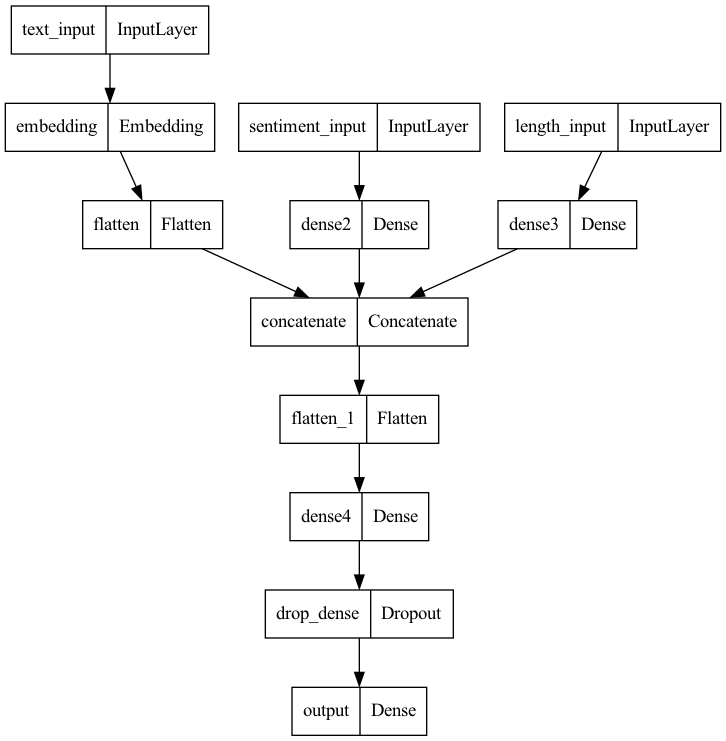

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [26]:
train_padded.shape, train_sentiment_scores.shape, train_sentence_lengths.shape

((825, 92), (825,), (825,))

In [27]:
train_token_data = tf.data.Dataset.from_tensor_slices((train_padded,
                                                       train_sentiment_scores, 
                                                       train_sentence_lengths))
# train_token_data = tf.data.Dataset.from_tensor_slices((train_padded))

train_labels = tf.data.Dataset.from_tensor_slices(y_train) # train labels
train_dataset = tf.data.Dataset.zip((train_token_data, train_labels)) # combine data and labels
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# x_train, x_valid, y_train, y_valid

test_token_data = tf.data.Dataset.from_tensor_slices((test_padded,
                                                       test_sentiment_scores, 
                                                       test_sentence_lengths))
test_labels = tf.data.Dataset.from_tensor_slices(y_valid) # train labels
test_dataset = tf.data.Dataset.zip((test_token_data, test_labels)) # combine data and labels
test_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
for data in train_dataset.take(1):
    print(data)

((<tf.Tensor: shape=(32, 92), dtype=int32, numpy=
array([[  0,   0,   0, ...,  85,   3,   7],
       [  0,   0,   0, ...,   1,   5, 258],
       [  0,   0,   0, ...,   3, 686,  57],
       ...,
       [  0,   0,   0, ...,   7,   1, 219],
       [  0,   0,   0, ...,   2, 239, 707],
       [  0,   0,   0, ...,  60, 110,  30]], dtype=int32)>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([ 0.02929513, -1.65728095,  0.02929513, -0.94740057,  0.02929513,
        0.02929513, -0.98178319,  0.02929513,  0.02929513, -1.40125409,
       -0.54816387,  1.55923859,  1.78349165,  0.70093927, -1.42280972,
        1.72411258,  0.02929513,  1.13967832, -1.34400505,  1.34992766,
        1.10696823, -0.85010232,  1.1230658 ,  0.02929513,  0.78659578,
        0.02929513,  1.77429273,  0.9984219 ,  0.02929513, -1.01568915,
        0.67030176,  0.79245815])>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([-0.87841672,  2.75519256, -0.70941164, -0.45590401,  1.06514173,
       -0.54040656, -0.9

In [29]:
train_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 92), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [30]:
model.fit(train_dataset, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          validation_data=test_dataset, 
          callbacks=[modelcheckpoint])

Epoch 1/4
19/26 [====================>.........] - ETA: 0s - loss: 0.5934 - accuracy: 0.7089WARNING:tensorflow:Model was constructed with shape (None, 92) for input KerasTensor(type_spec=TensorSpec(shape=(None, 92), dtype=tf.int16, name='text_input'), name='text_input', description="created by layer 'text_input'"), but it was called on an input with incompatible shape (None, None, 92).


2023-02-28 10:54:52.882836: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/qm/65x5tqmj70g82dzl_jscxj3r0000gn/T/ipykernel_25008/445345889.py", line 1, in <module>
      model.fit(train_dataset,
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1694, in fit
      val_logs = self.evaluate(
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/Users/aninditakundu/pytorch-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1803, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Cannot batch tensors with different shapes in component 0. First element had shape [32,92] and element 25 had shape [25,92].
	 [[{{node IteratorGetNext}}]] [Op:__inference_test_function_1806]

In [ ]:
len(test_sequences)

In [ ]:
len(train_sequences)

In [ ]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [ ]:
testdata = pd.read_csv("./data/groundtruth.csv")

In [ ]:
testdata.head()

In [ ]:
x_test = testdata['Text']

In [ ]:
test_xsequences = tokenizer.texts_to_sequences(x_test)
test_xpadded = pad_sequences(test_xsequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen, value=0.0)

In [ ]:
# combining UFS sentences and CFS sentences into FC sentences
testdata.loc[testdata['Verdict'] == 1, 'label'] = 1
testdata.loc[testdata['Verdict'] == 0, 'label'] = 1
testdata.loc[testdata['Verdict'] == -1, 'label'] = 0

In [ ]:
testdata.head()

In [ ]:
y_hat = model.predict(test_xpadded)

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
y = testdata['label'].astype(np.int64)
y.value_counts()

In [ ]:
"{:0.2f}".format(roc_auc_score(y, y_hat)*100.0)

In [ ]:
y